## Visualizing integration of all immune cell types across multiple disease tissues
## Fan Zhang
## 2020-05-18

In [1]:
library(Seurat)
library(harmony)
library(magrittr)
library(gridExtra)
library(ggthemes)
library(cowplot)
library(reticulate)
library(ggbeeswarm)
library(ggrepel)
library(plyr)
library(ggplot2)
library(gridExtra)
library(ggthemes)
library(dplyr)
library(Seurat)
library(RColorBrewer)
library(ggbeeswarm)
library(ggrepel)
library(MASS) 
library(matrixStats)
library(viridis)
library(grid)
require(gdata)


suppressMessages({
                  library(data.table)
                  library(reticulate)
                  library(Rcpp)
                  library(scales)
                  library(irlba)
                  library(singlecellmethods)
                  library(parallel)
                  library(pbapply)
                  library(patchwork)
                  library(pheatmap)
                  library(entropy)
                  library(Rtsne)
                  library(loe)
                  library(igraph)
                  library(viridis)
                  library(matrixStats)
                  library(plyr)
                  library(RColorBrewer)
                 })


library(RcppArmadillo)

meta_colors <- list(

  disease = c(

    "healthy" = "#B3B3B3",
    "mild"   = "#B2DF8A",
    "severe" = "#33A02C",
   
    "Healthy BALF" = "#B3B3B3",
    "Mild COVID-19"   = "#B2DF8A", 
    "Severe COVID-19" = "#33A02C",
      
    "Inflamed UC" = "#A6761D", 
    "Non-inflamed UC" = "#E6AB02", 
    "Healthy colon" = "#E5D8BD", 
    "Healthy kidney" = "#A6CEE3",
    "Healthy Lung" = "#C7EAE5", # healthy vs Pulmonary Fibrosis
    "Polymyositis lung" = "#80CDC1",
    "SS Lung" = "#003C30",
    "Systemic sclerosis lung" = "#003C30",
    "HP Lung" = "#35978F",
    "Hypersensitivity pneumonitis lung" = "#35978F",
    "Crohn" = "#FF7F00", 
    "Healthy kidney" = "#1F8888",
    "SLE kidney" = "#1F78B4",   
    "RA synovium" =  "#E31A1C", #"#6A3D9A", 
    "OA synovium"  =  "#FB9A99", # "#FB9A99", # "#CAB2D6",
      
    "MS brain" = "#6A3D9A",
    "Healthy brain" = "#CAB2D6",
      
    "Inflamed IBD" = "#A6761D", 
    "Non-inflamed IBD" = "#E6AB02", 
    "healthy (IBD)" = "#E5D8BD", 
    "Ctrl" = "#C7EAE5", # healthy vs Pulmonary Fibrosis
    "Polymyositis" = "#80CDC1",
    "Systemic sclerosis" = "#003C30",
    "Hypersensitivity pneumonitis" = "#35978F",

    "SLE" = "#1F78B4",   
    "RA" =  "#E31A1C", #"#6A3D9A", 
    "OA"  =  "black", # "#FB9A99", # "#CAB2D6",
    "MS" = "#33A02C",
    "Multiple sclerosis" = "#33A02C"
      
  ),
    
    
  "dataset" = c(    
    "AMP SLE Phase 1 Celseq" = "#006837",
    "AMP SLE Phase 1 Fluidigm" = "#ADDD8E",
    "RA" = "#6A3D9A", # "#E31A1C",  
    "AMP RA" = "#6A3D9A", # "#E31A1C",  
    "AMP RA Phase 1" = "#E31A1C",
    "Rahul" = "#FC8D62",
    "Crohn (Venema)" = "#FF7F00", 
    "UC (Smillie)" = "#A6761D",
    "Lung disease (Reyfman)" = "#7570B3",
    "AMP SLE" = "#1F78B4", 
    "RA" = "#E31A1C",
    "MS (Jäkel)" = "#33A02C",
    "MS (Schirmer)" = "#33A02C"
  )
)

set3 = c("#8DD3C7", "#FFFFB3", "#BEBADA", "#FB8072", "#80B1D3", "#FDB462", "#B3DE69", "#FCCDE5", "#D9D9D9", "#BC80BD", "#CCEBC5", "#FFED6F")
set2 = c("#66C2A5", "#FC8D62", "#8DA0CB", "#E78AC3", "#A6D854", "#FFD92F", "#E5C494", "#B3B3B3")
colors37 = c("#466791","#60bf37","#953ada","#4fbe6c","#ce49d3","#a7b43d","#5a51dc","#d49f36","#552095","#507f2d","#db37aa","#84b67c","#a06fda","#df462a","#5b83db","#c76c2d","#4f49a3","#82702d","#dd6bbb","#334c22","#d83979","#55baad","#dc4555","#62aad3","#8c3025","#417d61","#862977","#bba672","#403367","#da8a6d","#a79cd4","#71482c","#c689d0","#6b2940","#d593a7","#895c8b","#bd5975")

Loading required package: Rcpp
Warning message:
“package ‘cowplot’ was built under R version 3.6.3”
********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggthemes’:

    theme_map

Loading required package: ggplot2
Warning message:
“package ‘ggrepel’ was built under R version 3.6.3”Warning message:
“package ‘dplyr’ was built under R version 3.6.3”
Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from ‘package:gridExtra’:

    combine

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘pac

In [2]:
# Functions
FindVariableGenesBatch <- function(exprs_mat, meta_df, genes_exclude = NULL, ngenes_use = 1e3, expr_min = .1) {
    if (!is.null(genes_exclude)) {
        genes_use <- setdiff(row.names(exprs_mat), genes_exclude)
    }
    x_res <- split(meta_df$cell, meta_df$sample) %>% lapply(function(x) {
        FindVariableGenesSeurat(exprs_mat[genes_use, x]) %>% 
            subset(gene.mean >= expr_min) %>% 
            tibble::rownames_to_column("gene") %>% 
            dplyr::arrange(-gene.dispersion) %>%
            head(ngenes_use)
    })
    data.table(Reduce(rbind, x_res))[, .N, by = gene][order(-N)]    
}



FindVariableGenesSeurat <- function (data, x.low.cutoff = 0.1, x.high.cutoff = 8,
                                     y.cutoff = 1, y.high.cutoff = Inf, num.bin = 0,
                                     binning.method = "equal_width", sort.results = TRUE,
                                     display.progress = TRUE, ...)
{
    genes.use <- rownames(data)
    if (class(data) != "dgCMatrix") {
        data <- as(as.matrix(data), "dgCMatrix")
    }
    ## (1) get means and variances
    gene.mean <- FastExpMean(data, display.progress)
    names(gene.mean) <- genes.use
    gene.dispersion <- FastLogVMR(data, display.progress)
    names(gene.dispersion) <- genes.use

    gene.dispersion[is.na(x = gene.dispersion)] <- 0
    gene.mean[is.na(x = gene.mean)] <- 0

    mv.df <- data.frame(gene.mean, gene.dispersion)
    rownames(mv.df) <- rownames(data)

    ## (OPTIONAL) do the binning correction
    if (num.bin > 0) {
      if (binning.method == "equal_width") {
          data_x_bin <- cut(x = gene.mean, breaks = num.bin)
      }
      else if (binning.method == "equal_frequency") {
          data_x_bin <- cut(x = gene.mean, breaks = c(-1, quantile(gene.mean[gene.mean >
              0], probs = seq(0, 1, length.out = num.bin))))
     }
      else {
          stop(paste0("Invalid selection: '", binning.method,
              "' for 'binning.method'."))
      }
      names(x = data_x_bin) <- names(x = gene.mean)
      mean_y <- tapply(X = gene.dispersion, INDEX = data_x_bin,
          FUN = mean)
      sd_y <- tapply(X = gene.dispersion, INDEX = data_x_bin,
          FUN = sd)
      gene.dispersion.scaled <- (gene.dispersion - mean_y[as.numeric(x = data_x_bin)])/sd_y[as.numeric(x = data_x_bin)]
      gene.dispersion.scaled[is.na(x = gene.dispersion.scaled)] <- 0
      ##names(gene.dispersion.scaled) <- names(gene.mean)

      mv.df$gene.dispersion.scaled <- gene.dispersion.scaled
    }

    return(mv.df)
}

environment(FindVariableGenesSeurat) <- asNamespace("Seurat")

ScaleDataSeurat <- function (data.use, margin = 1, scale.max = 10,
                                block.size = 1000) {

    if (margin == 2) data.use %<>% t
    max.block <- ceiling(nrow(data.use)/block.size)

    ## Define data and functions to use in sparse and dense cases
    if (class(data.use) == "dgCMatrix" | class(data.use) == "dgTMatrix") {
        scale_fxn <- function(x) {
            FastSparseRowScale(mat = x, scale = TRUE, center = TRUE,
                               scale_max = scale.max, display_progress = FALSE)
        }
    } else {
        scale_fxn <- function(x) {
            FastRowScale(mat = x, scale = TRUE, center = TRUE,
                               scale_max = scale.max, display_progress = FALSE)
       }
        data.use <- as.matrix(data.use)
    }

    ## Do scaling, at once or in chunks
    if (max.block == 1) {
        scaled.data <- scale_fxn(data.use)
    } else {
        scaled.data <- matrix(NA, nrow(data.use), ncol(data.use))
        for (i in 1:max.block) {
            idx.min <- (block.size * (i - 1))
            idx.max <- min(nrow(data.use), (block.size * i - 1) + 1)
            my.inds <- idx.min:idx.max
            scaled.data[my.inds, ] <- scale_fxn(data.use[my.inds, , drop = F])
        }
    }

    colnames(scaled.data) <- colnames(data.use)
    row.names(scaled.data) <- row.names(data.use)
    scaled.data[is.na(scaled.data)] <- 0
    if (margin == 2) scaled.data %<>% t
    return(scaled.data)
}
environment(ScaleDataSeurat) <- asNamespace("Seurat")


fig.size <- function(height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}

SingleFeaturePlotSeurat <- function (data.use, feature, data.plot, pt.size, pch.use, cols.use,
    dim.codes, min.cutoff, max.cutoff, coord.fixed, no.axes,
    no.title = FALSE, no.legend, dark.theme, vector.friendly = FALSE,
    png.file = NULL, png.arguments = c(10, 10, 100))
{
    if (vector.friendly) {
        previous_call <- blank_call <- png_call <- match.call()
        blank_call$pt.size <- -1
        blank_call$vector.friendly <- FALSE
        png_call$no.axes <- TRUE
        png_call$no.legend <- TRUE
        png_call$vector.friendly <- FALSE
        png_call$no.title <- TRUE
        blank_plot <- eval(blank_call, sys.frame(sys.parent()))
        png_plot <- eval(png_call, sys.frame(sys.parent()))
        png.file <- SetIfNull(x = png.file, default = paste0(tempfile(),
            ".png"))
        ggsave(filename = png.file, plot = png_plot, width = png.arguments[1],
            height = png.arguments[2], dpi = png.arguments[3])
        to_return <- AugmentPlot(blank_plot, png.file)
        file.remove(png.file)
        return(to_return)
    }
    idx.keep <- which(!is.na(data.use[feature, ]))
    data.gene <- data.frame(data.use[feature, idx.keep])
#     data.gene <- na.omit(object = data.frame(data.use[feature,
#         ]))
    min.cutoff <- SetQuantile(cutoff = min.cutoff, data = data.gene)
    max.cutoff <- SetQuantile(cutoff = max.cutoff, data = data.gene)
    data.gene <- sapply(X = data.gene, FUN = function(x) {
        return(ifelse(test = x < min.cutoff, yes = min.cutoff,
            no = x))
    })
    data.gene <- sapply(X = data.gene, FUN = function(x) {
        return(ifelse(test = x > max.cutoff, yes = max.cutoff,
            no = x))
    })
    data_plot <- data.plot[idx.keep, ]
    data_plot$gene <- data.gene
    if (length(x = cols.use) == 1) {
        brewer.gran <- brewer.pal.info[cols.use, ]$maxcolors
    }
    else {
        brewer.gran <- length(x = cols.use)
    }
    if (all(data.gene == 0)) {
        data.cut <- 0
    }
    else {
        data.cut <- as.numeric(x = as.factor(x = cut(x = as.numeric(x = data.gene),
            breaks = brewer.gran)))
    }
    data_plot$col <- as.factor(x = data.cut)
    p <- data_plot %>%
        dplyr::arrange(col) %>%
        ggplot(mapping = aes(x = x, y = y))
    if (brewer.gran != 2) {
        if (length(x = cols.use) == 1) {
            p <- p + geom_point(mapping = aes(color = col), size = pt.size,
                shape = pch.use) + #scale_color_brewer(palette = cols.use)
                scale_color_viridis(option = "plasma", end = .9)
        }
        else {
            p <- p + geom_point(mapping = aes(color = col), size = pt.size,
                shape = pch.use) + #scale_color_manual(values = cols.use)
                scale_color_viridis(option = "plasma", end = .9)
        }
    }
    else {
        if (all(data_plot$gene == data_plot$gene[1])) {
            warning(paste0("All cells have the same value of ",
                feature, "."))
            p <- p + geom_point(color = cols.use[1], size = pt.size,
                shape = pch.use)
        }
        else {
            p <- p + geom_point(mapping = aes(color = gene),
                size = pt.size, shape = pch.use) + scale_color_viridis(option = "plasma", end = .9
    )
        }
    }
    if (dark.theme) {
        p <- p + DarkTheme()
    }
    if (no.axes) {
        p <- p + theme(axis.line = element_blank(), axis.text.x = element_blank(),
            axis.text.y = element_blank(), axis.ticks = element_blank(),
            axis.title.x = element_blank(), axis.title.y = element_blank())
        if (!no.title)
            p <- p + labs(title = feature, x = "", y = "")
        if (no.title)
            p <- p + labs(x = "", y = "")
    }
    else {
        if (no.title)
            p <- p + labs(x = dim.codes[1], y = dim.codes[2])
        if (!(no.title))
            p <- p + labs(title = feature) + labs(x = "", y = "")
    }
    if (no.legend) {
        p <- p + theme(legend.position = "none")
    }
    if (coord.fixed) {
        p <- p + coord_fixed()
    }
    return(p)
}
environment(SingleFeaturePlotSeurat) <- asNamespace("Seurat")

PlotFeatures <- function(umap_use, features_plot, exprs_use, cells_use, ncols, pt_size = .5, pt_shape = ".", q_lo = "q10", q_hi = "q90") {
    if (missing(cells_use)) cells_use <- 1:nrow(umap_use)
    if (missing(ncols)) ncols <- round(sqrt(length(features_plot)))
    
    plt_list <- lapply(features_plot, function(feature_use) {
        SingleFeaturePlotSeurat(exprs_use[, cells_use], feature_use, data.frame(x = umap_use[cells_use, 1], y = umap_use[cells_use, 2]),
                                pt.size = pt_size, pch.use = pt_shape, cols.use = c("lightgrey", "blue"),
                                dim.codes = c("UMAP 1", "UMAP 2"), min.cutoff = c(q10 = q_lo), max.cutoff = c(q90 = q_hi),
                                coord.fixed = FALSE, no.axes = FALSE, dark.theme = FALSE, no.legend = TRUE)
    })
    plot_grid(plotlist = plt_list, ncol = ncols)
    #return(plt_list)
}

BuildSNNSeurat <- function (data.use, k.param = 30, prune.SNN = 1/15, nn.eps = 0) {
    my.knn <- nn2(data = data.use, k = k.param, searchtype = "standard", eps = nn.eps)
    nn.ranked <- my.knn$nn.idx

    snn_res <- ComputeSNN(nn_ranked = nn.ranked, prune = prune.SNN)
    rownames(snn_res) <- row.names(data.use)
    colnames(snn_res) <- row.names(data.use)
    return(snn_res)
}
environment(BuildSNNSeurat) <- asNamespace("Seurat")

NormalizeDataSeurat <- function(A, scaling_factor = 1e4, do_ftt = FALSE) {
	A@x <- A@x / rep.int(Matrix::colSums(A), diff(A@p))
    A@x <- scaling_factor * A@x
    if (do_ftt) {
        A@x <- sqrt(A@x) + sqrt(1 + A@x)
    } else {
        A@x <- log(1 + A@x)
    }
	return(A)
}


# Visualize results

In [3]:
meta_all <- readRDS("meta_all_COVID19_RA_Rahul_SLE_UC_Crohn_MS_lung_pca_umap_harmony_umap_cluster_new_new_new_2020-05-26.rds")
exprs_norm <- readRDS("exprs_norm_COVID19_RA_Rahul_SLE_UC_Crohn_MS_lung_pca_harmony_umap_cluster_new_new_2020-05-26.rds")

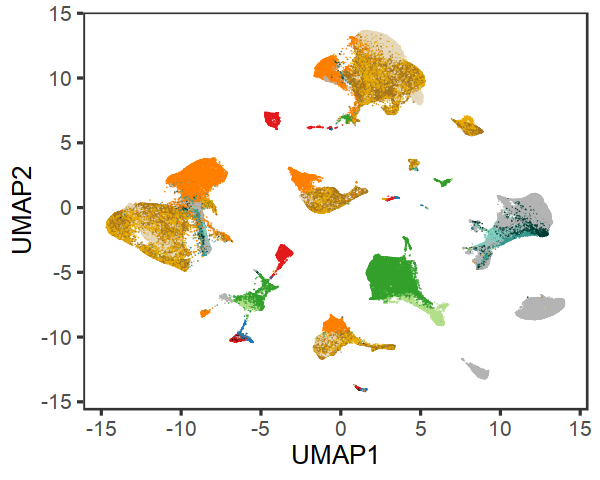

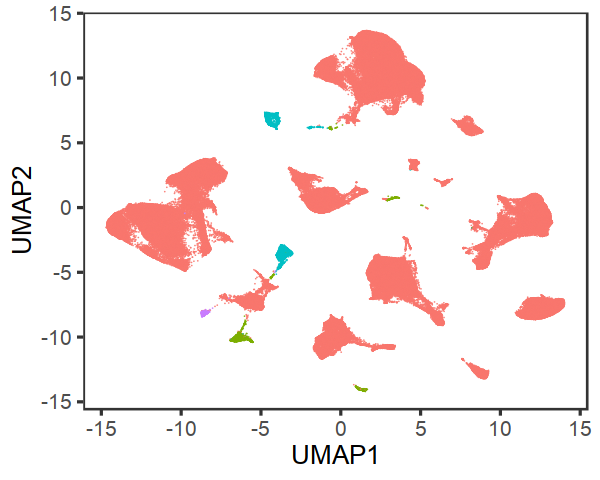

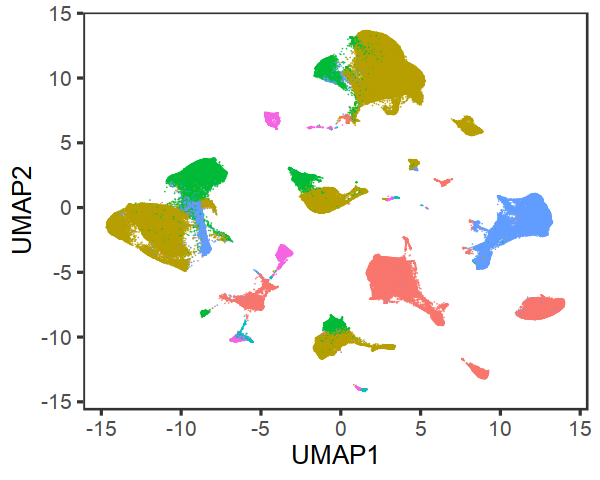

In [8]:
options(repr.plot.height = 4, repr.plot.width = 5)
ggplot(meta_all[sample(nrow(meta_all)),],
       aes(x = UMAP1_before, y = UMAP2_before, fill= disease)
      ) +
  geom_point(size = 0.2, stroke = 0.0001, shape = 21, alpha = 0.9) +
  scale_fill_manual(values = meta_colors$disease, name = "") +
  labs(
      x = "UMAP1",
      y = "UMAP2"
      ) +
  theme_bw(base_size = 15) +
  theme(
    legend.position = "none",
#     axis.text = element_blank(),
#     axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=20, face = "italic")
)
ggsave(file = paste("before_harmony_1", ".png", sep = ""), width = 5, height = 4, dpi = 300)


ggplot(meta_all[sample(nrow(meta_all)),],
       aes(x = UMAP1_before, y = UMAP2_before, fill= technology)
      ) +
  geom_point(size = 0.2, stroke = 0.0001, shape = 21, alpha = 0.9) +
#   scale_fill_manual(values = meta_colors$disease, name = "") +
  labs(
      x = "UMAP1",
      y = "UMAP2"
      ) +
  theme_bw(base_size = 15) +
  theme(
    legend.position = "none",
#     axis.text = element_blank(),
#     axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=20, face = "italic")
)
ggsave(file = paste("before_harmony_2", ".png", sep = ""), width = 5, height = 4, dpi = 300)


ggplot(meta_all[sample(nrow(meta_all)),],
       aes(x = UMAP1_before, y = UMAP2_before, fill= tissue)
      ) +
  geom_point(size = 0.2, stroke = 0.0001, shape = 21, alpha = 0.9) +
#   scale_fill_manual(values = meta_colors$disease, name = "") +
  labs(
      x = "UMAP1",
      y = "UMAP2"
      ) +
  theme_bw(base_size = 15) +
  theme(
    legend.position = "none",
#     axis.text = element_blank(),
#     axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=20, face = "italic")
)
ggsave(file = paste("before_harmony_3", ".png", sep = ""), width = 5, height = 4, dpi = 300)

Warning message:
“Factor `cell_type` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Removed 1 rows containing missing values (geom_label_repel).”

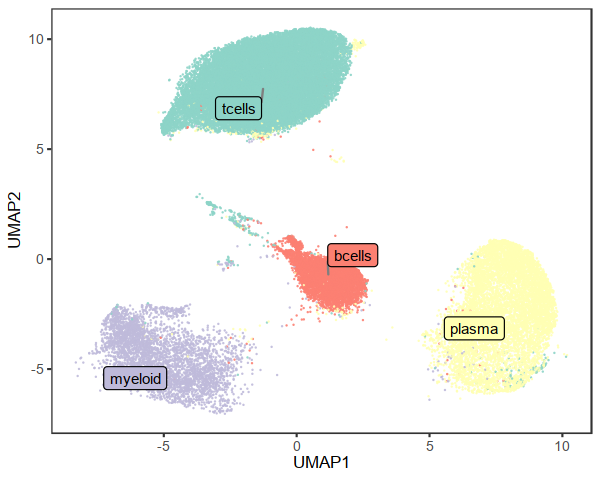

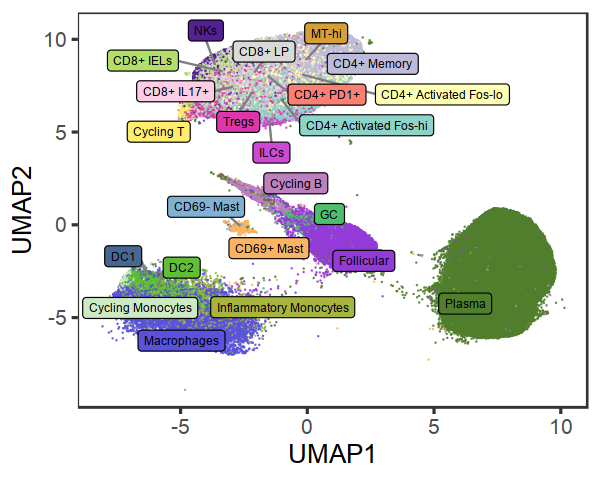

In [24]:
cluster_center <- meta_all[which(meta_all$dataset == "Martin"),] %>%
                  group_by(cell_type) %>%
                  summarise_at(vars(harmonized_UMAP1, harmonized_UMAP2), funs(median(., na.rm=TRUE)))
cluster_center <- as.data.frame(cluster_center)
cluster_center$cell_type <- as.character(cluster_center$cell_type)

options(repr.plot.height = 4, repr.plot.width = 5)
ggplot(meta_all[which(meta_all$dataset == "Martin"),],
       aes(x = harmonized_UMAP1, y = harmonized_UMAP2, fill= cell_type)
      ) +
  geom_point(size = 0.4, stroke = 0.0001, shape = 21, alpha = 0.9) +
  geom_label_repel(
    data = cluster_center,
    aes(label = cell_type, fill = cell_type),
#     fontface = 'bold', 
    size = 3, 
    box.padding = unit(0.2, "lines"),
    point.padding = unit(0.2, "lines"),
    segment.color = 'grey50'
  ) +
  scale_fill_manual(values = c(set3, colors37), name = "") +
  labs(
      x = "UMAP1",
      y = "UMAP2"
      ) +
  theme_bw(base_size = 10) +
  theme(
    legend.position = "none",
#     axis.text = element_blank(),
#     axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=10, face = "italic")
)


uc_meta <- meta_all[which(meta_all$dataset == "IBD"),]
cluster_center <- uc_meta %>%
                  group_by(cell_type) %>%
                  summarise_at(vars(harmonized_UMAP1, harmonized_UMAP2), funs(median(., na.rm=TRUE)))
cluster_center <- as.data.frame(cluster_center)
cluster_center$cell_type <- as.character(cluster_center$cell_type)

ggplot(uc_meta[sample(nrow(uc_meta)),],
       aes(x = harmonized_UMAP1, y = harmonized_UMAP2, fill= cell_type)
      ) +
  geom_point(size = 0.4, stroke = 0.0001, shape = 21, alpha = 0.9) +
  geom_label_repel(
    data = cluster_center,
    aes(label = cell_type, fill = cell_type),
#     fontface = 'bold', 
    size = 2.5, 
    box.padding = unit(0.2, "lines"),
    point.padding = unit(0.2, "lines"),
    segment.color = 'grey50'
  ) +
  scale_fill_manual(values = c(set3, colors37), name = "") +
  labs(
      x = "UMAP1",
      y = "UMAP2"
      ) +
  theme_bw(base_size = 15) +
  theme(
    legend.position = "none",
#     axis.text = element_blank(),
#     axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=10, face = "italic")
)
ggsave(file = paste("UC_original_annotation", ".png", sep = ""), width = 5, height = 4, dpi = 300)

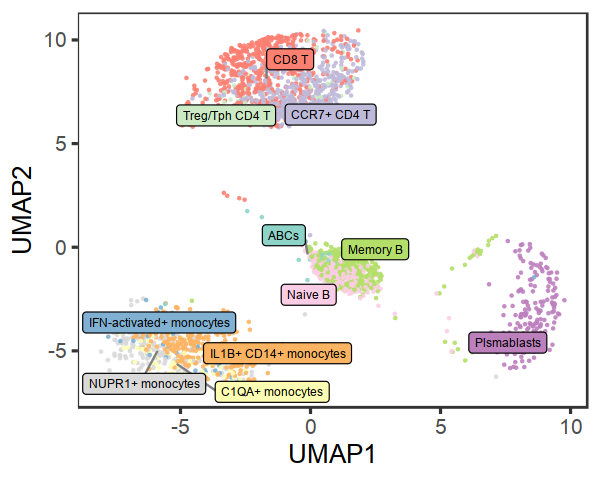

In [21]:
meta_ra <- meta_all[which(meta_all$dataset == "AMP RA"),]
meta_ra$cell_type <- as.character(meta_ra$cell_type)
meta_ra$cell_type[which(meta_ra$cell_type %in% c("SC-T1", "SC-T2"))] <- "CCR7+ CD4 T"
meta_ra$cell_type[which(meta_ra$cell_type %in% c("SC-T3"))] <- "Treg/Tph CD4 T"
meta_ra$cell_type[which(meta_ra$cell_type %in% c("SC-T4", "SC-T5", "SC-T6"))] <- "CD8 T"
meta_ra$cell_type[which(meta_ra$cell_type %in% c("SC-B1"))] <- "Naive B"
meta_ra$cell_type[which(meta_ra$cell_type %in% c("SC-B2"))] <- "Memory B"
meta_ra$cell_type[which(meta_ra$cell_type %in% c("SC-B3"))] <- "ABCs"
meta_ra$cell_type[which(meta_ra$cell_type %in% c("SC-B4"))] <- "Plsmablasts"
meta_ra$cell_type[which(meta_ra$cell_type %in% c("SC-M1"))] <- "IL1B+ CD14+ monocytes"
meta_ra$cell_type[which(meta_ra$cell_type %in% c("SC-M4"))] <- "IFN-activated+ monocytes"
meta_ra$cell_type[which(meta_ra$cell_type %in% c("SC-M3"))] <- "C1QA+ monocytes"
meta_ra$cell_type[which(meta_ra$cell_type %in% c("SC-M2"))] <- "NUPR1+ monocytes"


cluster_center <- meta_ra %>%
                  group_by(cell_type) %>%
                  summarise_at(vars(harmonized_UMAP1, harmonized_UMAP2), funs(median(., na.rm=TRUE)))
cluster_center <- as.data.frame(cluster_center)
cluster_center$cell_type <- as.character(cluster_center$cell_type)

ggplot(meta_ra,
       aes(x = harmonized_UMAP1, y = harmonized_UMAP2, fill= cell_type)
      ) +
  geom_point(size = 1, stroke = 0.0001, shape = 21, alpha = 0.9) +
  geom_label_repel(
    data = cluster_center,
    aes(label = cell_type, fill = cell_type),
#     fontface = 'bold', 
    size = 2.5, 
    box.padding = unit(0.2, "lines"),
    point.padding = unit(0.2, "lines"),
    segment.color = 'grey50'
  ) +
  scale_fill_manual(values = c(set3, colors37), name = "") +
  labs(
      x = "UMAP1",
      y = "UMAP2"
      ) +
 theme_bw(base_size = 15) +
  theme(
    legend.position = "none",
#     axis.text = element_blank(),
#     axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=10, face = "italic")
)
ggsave(file = paste("RA_original_annotation", ".png", sep = ""), width = 5, height = 4, dpi = 300)

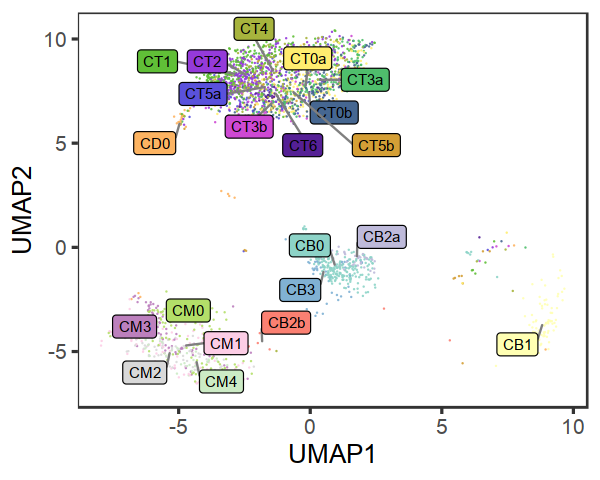

In [18]:

cluster_center <- meta_all[which(meta_all$dataset == "AMP SLE"),] %>%
                  group_by(cell_type) %>%
                  summarise_at(vars(harmonized_UMAP1, harmonized_UMAP2), funs(median(., na.rm=TRUE)))
cluster_center <- as.data.frame(cluster_center)
cluster_center$cell_type <- as.character(cluster_center$cell_type)


ggplot(meta_all[which(meta_all$dataset == "AMP SLE"),],
       aes(x = harmonized_UMAP1, y = harmonized_UMAP2, fill= cell_type)
      ) +
  geom_point(size = 0.4, stroke = 0.0001, shape = 21, alpha = 0.9) +
  geom_label_repel(
    data = cluster_center,
    aes(label = cell_type, fill = cell_type),
#     fontface = 'bold', 
    size = 3, 
    box.padding = unit(0.2, "lines"),
    point.padding = unit(0.2, "lines"),
    segment.color = 'grey50'
  ) +
  scale_fill_manual(values = c(set3, colors37), name = "") +
  labs(
      x = "UMAP1",
      y = "UMAP2"
      ) +
  theme_bw(base_size = 15) +
  theme(
    legend.position = "none",
#     axis.text = element_blank(),
#     axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=10, face = "italic")
)

In [34]:
library(presto)
genes_exclude <- grep("^MT-|^RPL|^RPS|MALAT1|MIR-", row.names(exprs_norm), value = TRUE)
vargenes_df <- FindVariableGenesBatch(exprs_norm, meta_all, genes_exclude, 0.15e3)
nrow(vargenes_df)
table(vargenes_df$N)
var_genes <- vargenes_df$gene
head(var_genes)

marker_res_0.40 <- wilcoxauc(exprs_norm[var_genes,], meta_all$res_0.40)
saveRDS(marker_res_0.40, "all_marker_genes_res_0.40_2020_05-17.rds")

marker_res_0.60 <- wilcoxauc(exprs_norm[var_genes,], meta_all$res_0.60)
saveRDS(marker_res_0.60, "all_marker_genes_res_0.60_2020_05-17.rds")

[1] 4981


   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
2852  865  347  170  115   89   58   37   36   30   20   19   21    8   16   18 
  17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32 
  13   11    9   16    5    7    4    6    7    4    7    2    7    3    7    4 
  33   34   35   36   37   38   39   40   41   42   43   44   45   46   47   48 
   5    3    4    4    3    8    3    4    5    2    4    5    4    3    4    2 
  49   50   51   52   53   54   55   56   57   58   61   62   63   64   65   66 
   2    2    2    1    1    3    3    2    3    2    1    1    1    3    1    2 
  67   68   69   70   71   72   73   74   76   77   79   80   81   82   85   86 
   2    3    2    1    4    3    1    3    1    1    1    5    4    2    2    5 
  88   90   92   94   96   97  100  103  104  105  106  107  108  109  111  112 
   3    1    1    1    2    2    1    2    2    1    3    1    2    2    1    1 
 117  121  122  128  131  1

[1] "CD74"    "FTL"     "HLA-DRA" "TMSB4X"  "CCL4"    "B2M"

In [5]:
# marker_broad <- wilcoxauc(exprs_norm[var_genes,], meta_all$broad_cell_type)
# saveRDS(marker_broad, "all_marker_genes_broad_cell_type_2020_05-17.rds")

x <- marker_broad %>%
  group_by(group) %>%
  top_n(5, wt = logFC) 

In [8]:
plot_gene <- c("CD14", "FCGR3A",  "S100A8", "MRC1", "CD1C",
               "CD3D", "CCR7", "CTLA4", "CD8A", "NKG7",
               "MS4A1", "MZB1", "MKI67", "TPSAB1")

plot_gene <- c("CD14", "FCGR3A", "CD1C",
               "CD3D", "NKG7",
               "MS4A1", "MZB1", "MKI67", "TPSAB1")
plot_gene %in% rownames(exprs_norm)

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

[1] 9

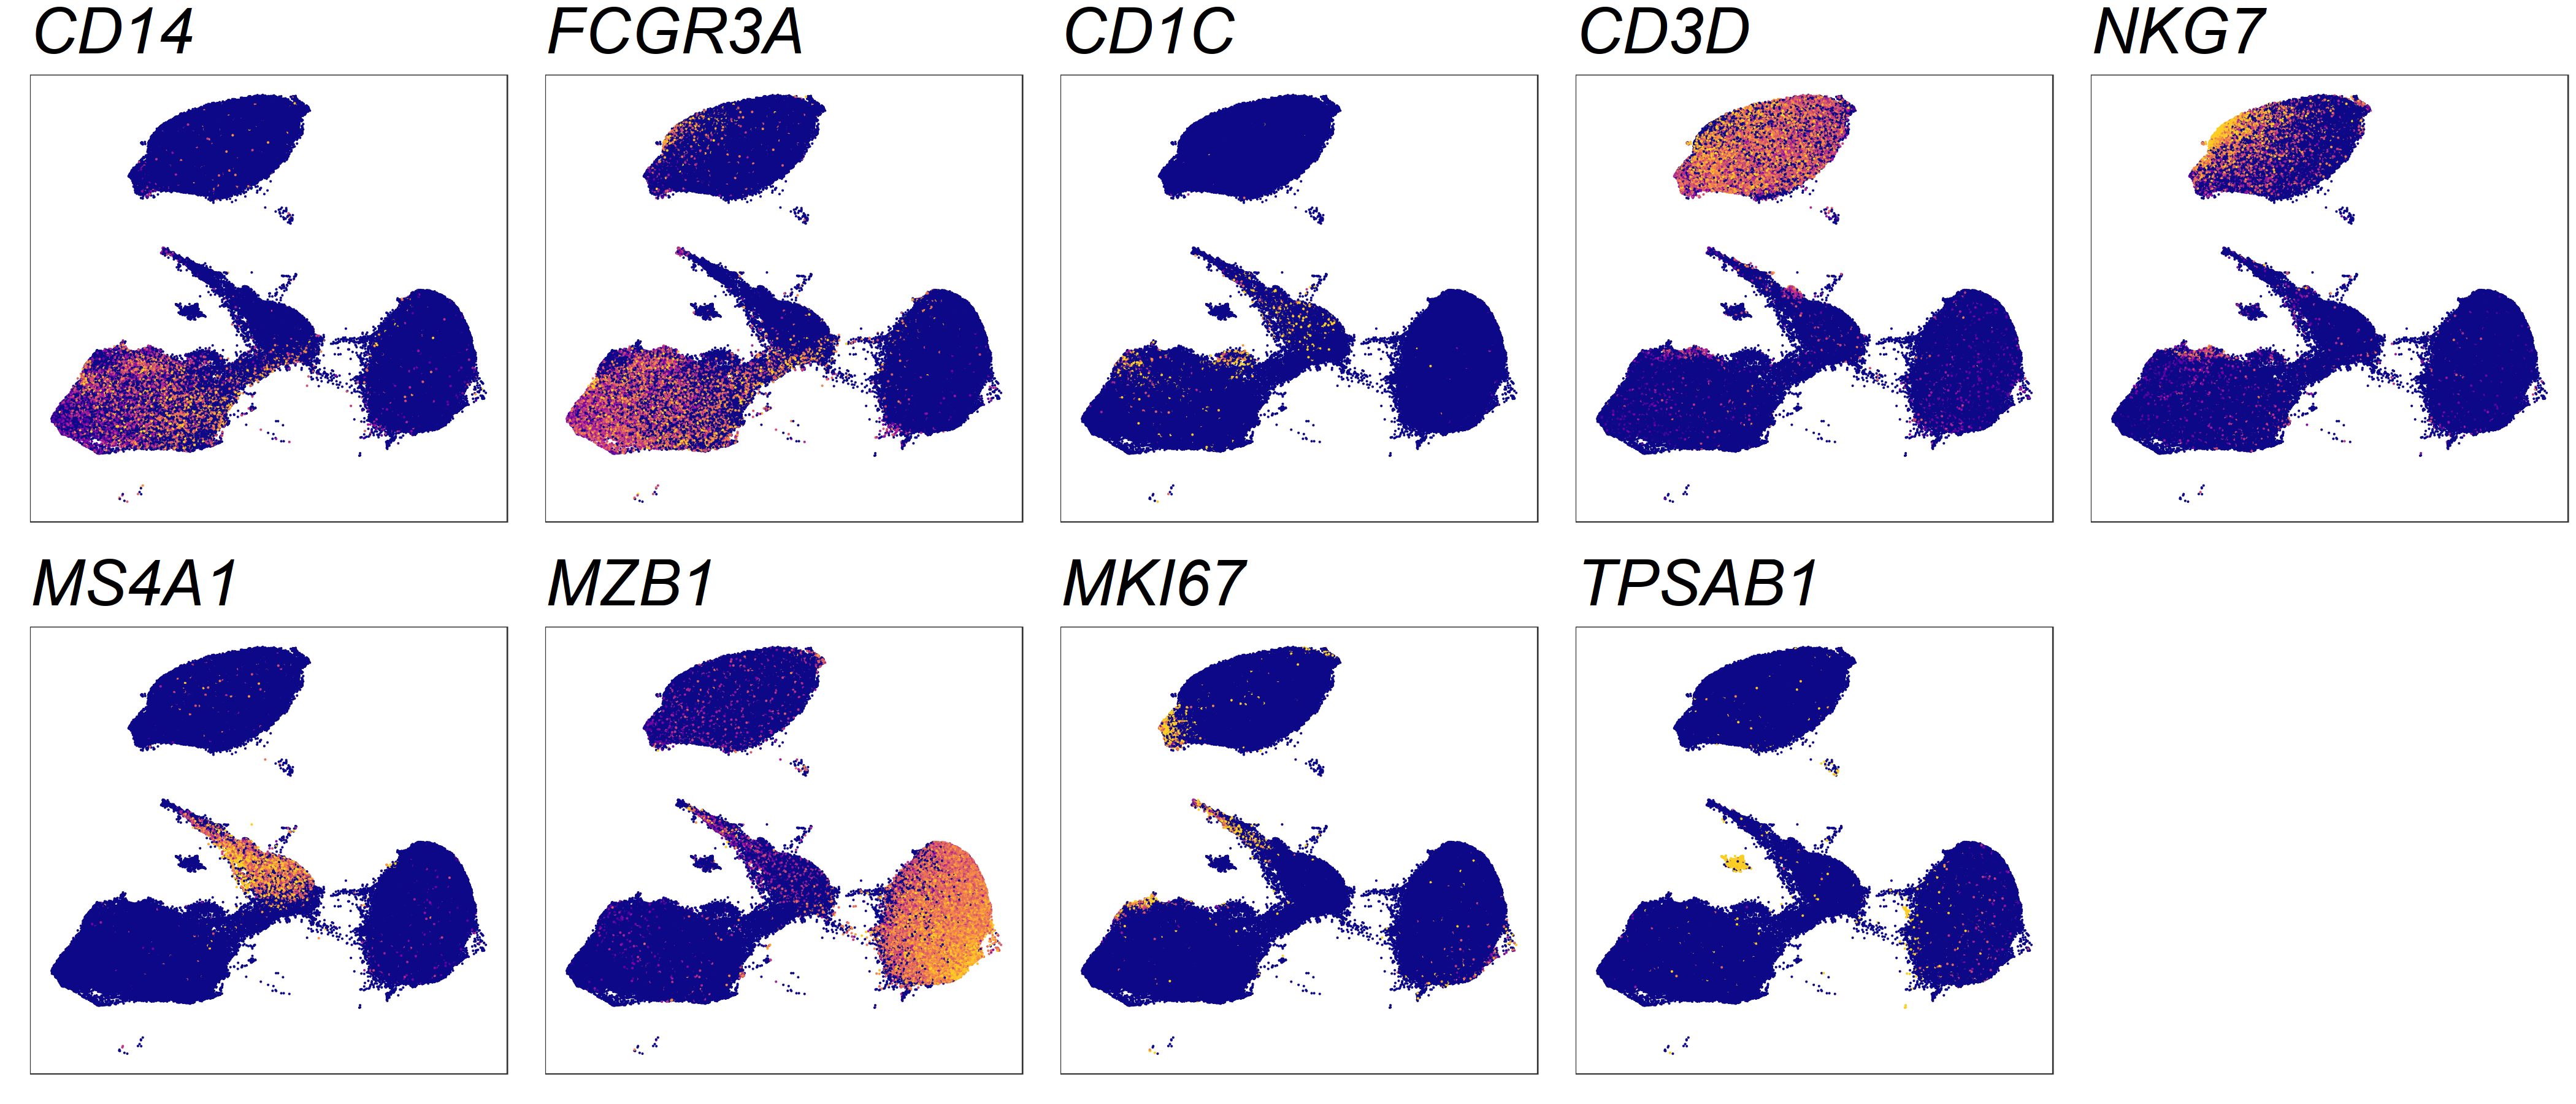

In [11]:

# plot_gene <- c(plot_gene, x$feature)
plot_gene <- unique(plot_gene)
length(plot_gene)

myplots <- list()
for (i in 1:length(plot_gene)) {
  gene <- plot_gene[i]
    
    max.cutoff = quantile(exprs_norm[gene,], .99)
    min.cutoff = quantile(exprs_norm[gene,], .01)

    tmp <- sapply(X = exprs_norm[gene,], FUN = function(x) {
        return(ifelse(test = x > max.cutoff, yes = max.cutoff,
            no = x))
    })
    tmp <- sapply(X = tmp, FUN = function(x) {
        return(ifelse(test = x < min.cutoff, yes = min.cutoff,
            no = x))
    })
  
    meta_all$gene <- as.numeric(tmp)

    
   ind <- paste("p", i, sep = "")
   ind <- ggplot(
                 data = meta_all[sample(nrow(meta_all)),],
#                  data = meta_all[order(meta_all$gene),] , 
                 aes(x = harmonized_UMAP1, y = harmonized_UMAP2)) + 
      geom_point(mapping = aes(color = gene), size = 0.1) + 
      scale_color_viridis(option = "plasma", end = .9) +
#       scale_color_brewer(palette = "Greens") +
      labs(x="", y="")+
      theme_bw(base_size = 15)+
      theme(
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        panel.grid = element_blank(),
        plot.title = element_text(color="black", size=62, face="italic"),
        legend.position = "none") +
      labs(title = gene)
   myplots[[i]] <- ind

}

options(repr.plot.height = 15, repr.plot.width = 35)
p <- do.call("grid.arrange", c(myplots, ncol = 5))
ggsave(file = paste("all_integration_marker_genes_v2", ".png", sep = ""), p, width = 35, height = 15, dpi = 300)

In [9]:
meta_all <- readRDS("meta_all_COVID19_RA_Rahul_SLE_UC_Crohn_MS_lung_pca_harmony_umap_cluster_new_new_new_2020-05-26.rds")
exprs_norm <- readRDS("exprs_norm_COVID19_RA_Rahul_SLE_UC_Crohn_MS_lung_pca_harmony_umap_cluster_new_new_2020-05-26.rds")

## Plot proportion of major cell type within each disease tissue

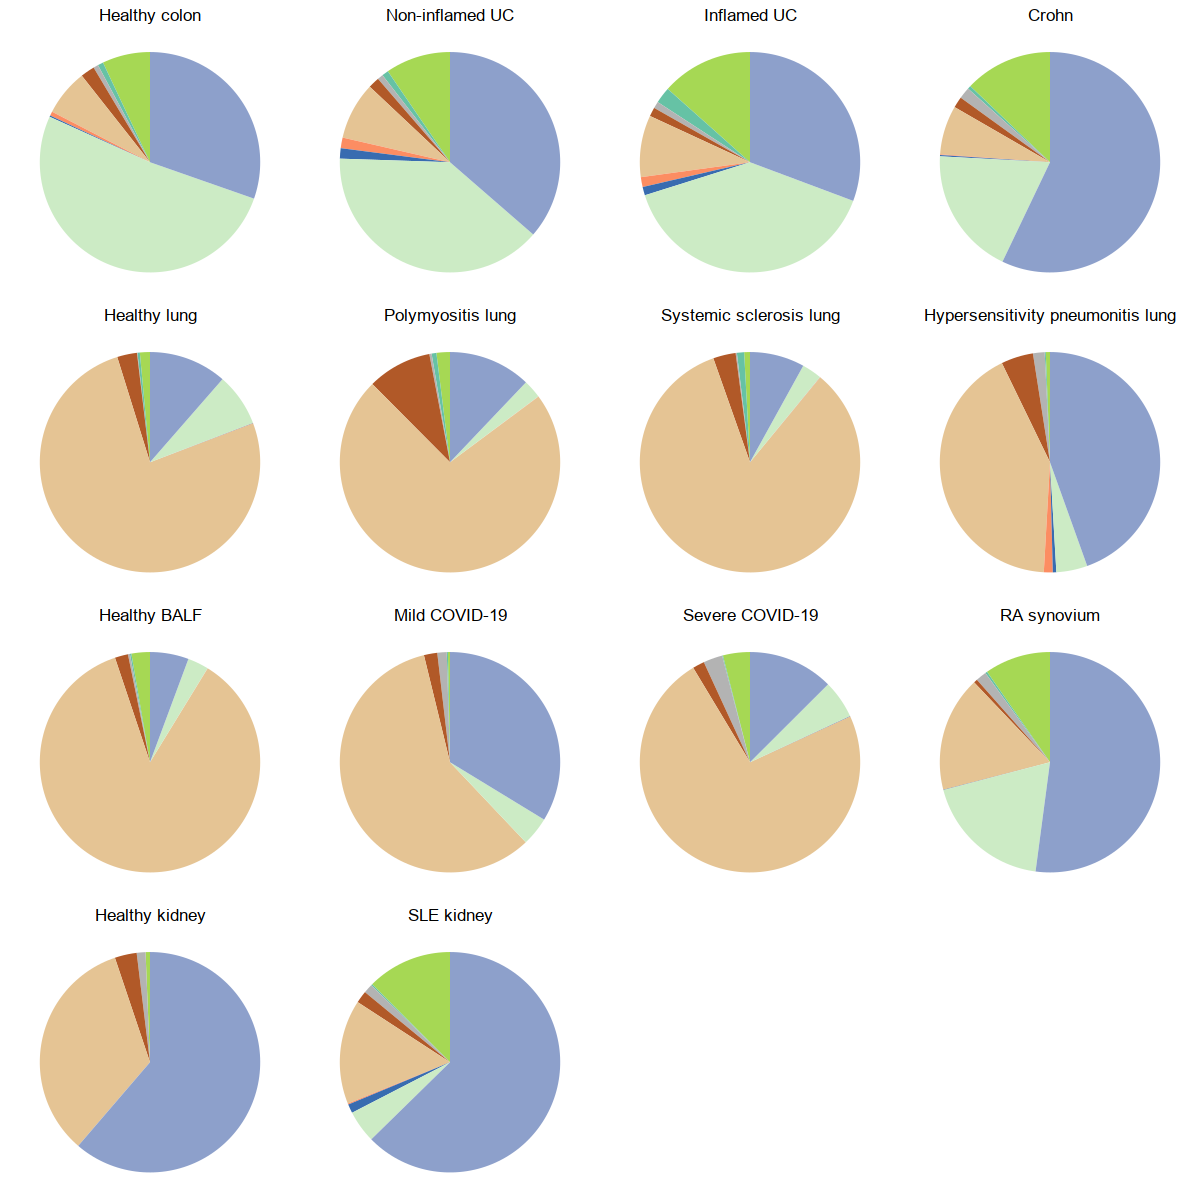

In [11]:
# Pie chart
temp <- as.data.frame(table(meta_all$broad_cell_type_nk_dc, meta_all$disease_new))
colnames(temp) <- c("annot", "disease", "num_cells")

options(repr.plot.height = 10, repr.plot.width = 10)
diag <- names(table(temp$disease))
diag <- c(
    'Healthy colon', 'Non-inflamed UC', 'Inflamed UC', 'Crohn',
    'Healthy lung', 'Polymyositis lung', 'Systemic sclerosis lung', 'Hypersensitivity pneumonitis lung',
    'Healthy BALF', 'Mild COVID-19', 'Severe COVID-19',
    'RA synovium', 'Healthy kidney', 'SLE kidney'
)

myplots <- list()
for (i in 1:length(diag)) {
  name  <- diag[i]
  df <- temp[which(temp$disease == name),]
  ind <- paste("p", i, sep = "")
  ind <- ggplot(df, aes(x="", y=num_cells, fill=annot))+ 
         geom_bar(width = 1, stat = "identity", position = "fill") +
#          geom_label_repel(aes(label = prop), size=2, show.legend = F, nudge_x = 1) +
#          guides(fill = guide_legend(title = "Group"))
         labs(title = name) +
         coord_polar("y", start=0) + 
         scale_fill_manual(values = meta_colors$broad_cell_type_nk_dc, name = "") +
         theme_void() +
         theme(
               legend.position = "none",
               plot.title = element_text(hjust = 0.5, size = 10))
  myplots[[i]] <- ind
}

p <- do.call("grid.arrange", c(myplots, ncol = 4))
ggsave(file = paste("broad_cell_type_pieplot", ".pdf", sep = ""), p, width = 10, height = 10, dpi = 300)

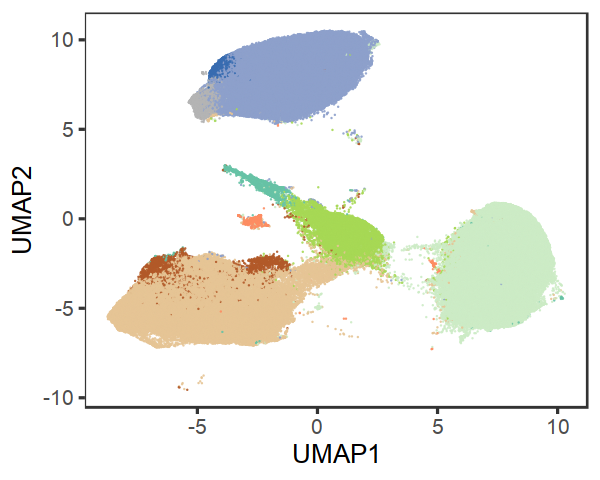

In [14]:
options(repr.plot.height = 4, repr.plot.width = 5)
ggplot(meta_all[sample(nrow(meta_all)),],
       aes(x = harmonized_UMAP1, y = harmonized_UMAP2, fill= broad_cell_type_nk_dc)
      ) +
  geom_point(size = 0.4, stroke = 0.0001, shape = 21, alpha = 0.9) +
  scale_fill_manual(values = meta_colors$broad_cell_type_nk_dc, name = "") +
  labs(
      x = "UMAP1",
      y = "UMAP2"
      ) +
  theme_bw(base_size = 15) +
  theme(
    legend.position = "none",
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=10, face = "italic")
)
ggsave(file = paste("all_integration_broad_cell_type", ".png", sep = ""), width = 5, height = 4, dpi = 300)

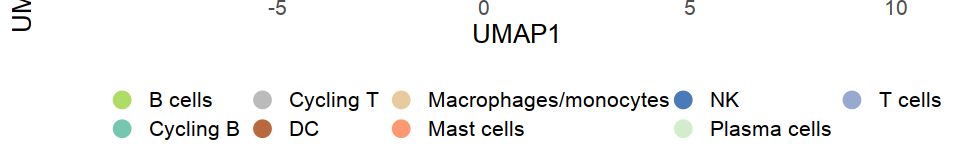

In [26]:
options(repr.plot.height = 1.2, repr.plot.width = 8)
ggplot(meta_all[sample(nrow(meta_all)),],
       aes(x = harmonized_UMAP1, y = harmonized_UMAP2, fill= broad_cell_type_nk_dc)
      ) +
  geom_point(size = 5, stroke = 0.0001, shape = 21, alpha = 0.9) +
  scale_fill_manual(values = meta_colors$broad_cell_type_nk_dc, name = "") +
  labs(
      x = "UMAP1",
      y = "UMAP2"
      ) +
  theme_bw(base_size = 15) +
  theme(
    legend.position = "bottom",
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=10, face = "italic")
)
ggsave(file = paste("all_integration_broad_cell_type_colorkey", ".pdf", sep = ""), width = 8, height = 1.2, dpi = 300)

In [6]:
meta_colors$broad_cell_type_nk_dc <- c(
    'B cells' = "#A6D854",
    'Cycling B' =  "#66C2A5", 
    'Cycling T' = "#B3B3B3",  
    'Macrophages/monocytes' ="#E5C494", 
    'DC' = "#B15928",
    'Mast cells' =  "#FC8D62", 
    'NK' =  "#386CB0",
    'Plasma cells' = "#CCEBC5", 
    'T cells' = "#8DA0CB"
)

## Generate table for single-cell datasets in Figure 1

In [65]:
sc_table <- meta_all %>% 
  group_by(disease, dataset, technology ) %>%
  summarise(number = n())

write.table(sc_table, file = paste("table_single-cell_datasets", ".txt", sep = ""),
             row.names=T,col.names=T, quote = F, sep = "\t")